# Machine Astrophysics

Introductory reading:
https://otherful.wordpress.com/2018/02/14/gozogon-an-introduction/

"The story takes place on the planet Gozogon, on an S-type orbit around Gnos in the Gnoslor binary system.
Except that the Gozogonians know very little about this because they have not discovered the physics of celestial objects, they don’t have a simple model of gravity.
They do however know, and can predict with precision, the location of any of the bodies they see in the sky, thanks to their supercomputer systems, interlinked across the planet wherever there is life.

In contrast to Earth, physics did not rise from the motion of celestial bodies...
... the first science to develop was not astronomy, it was biology (if we expand it to include what the Earthlings call psychology, sociology, etc). Gozogon did raise many genius scientists, only not in the directions that we had on Earth. The intricate relations between members of a species, and across species, was a more urgent matter and that was where the animals used their brains to figure out first. Going deeper, they discovered chemistry and eventually, physics of particles at smaller and smaller scales. They were able to manipulate what they learned from nature to invent and create new lifeforms, among which the distinguished entity called RedRoot rose."

This study explores the discovery potential of learning systems, how the data can be converted into formulas.

## Mars retrograde detection

The first case study is the retrograde motion of Mars from the perspective of Earth. This is a very simple system of two co-centric, almost circular, orbits where the external one appears to be moving backwards at certain times. 

Such a system was an important cornerstone in the history of astrophysics, that inspired Ptolemy for his epicycles to model the system, later to be replaced by a simpler model of Copernicus.

In [1]:
%%time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from Visualisations import *
%load_ext Cython

CPU times: user 1.06 s, sys: 142 ms, total: 1.2 s
Wall time: 1.28 s


In [2]:
%%time
%%cython
from Transformations import *
import Generate as gen

CPU times: user 3.16 ms, sys: 1.87 ms, total: 5.03 ms
Wall time: 4.51 ms


### Generate system

We simulate a system of two planets, rotating around a motionless sun. The orbits will be chosen to be almost circular, the challenge mostly concentrating on the retrograde motion which suggests a concentric motion of the two planets.
We will simulate the motion in 'n_sim' time steps, and sample every 'n_view'th of those steps as an observation point.

In [3]:
%%time
n_sample = 2000
n_sim = 20000
n_view = 10
s = gen.System(load=[])

#s.force = s.force_gravity
s.force = s.force_single_sun

#s.generate(2)
s.add_body(x=[49., 0.], v=[0., np.sqrt(0.0205)], m=0.00001)
s.add_body(x=[105., 0.], v=[0., 0.105], m=0.00001)
s.simulate(n_sim)
s.view(0, n_view)
t = np.arange(0, n_sim/n_view)*n_view


Adding body with spring length :  0.0
Adding body with spring length :  56.0
CPU times: user 1.73 s, sys: 85.5 ms, total: 1.82 s
Wall time: 1.9 s


### Write file

In [4]:
phis = s.get_phi(1)
time = np.arange(len(phis)) * n_sim/n_view
data = pd.DataFrame({'time': time, 'phi': phis})\
    .to_csv('test_angles_small.csv',
            columns=['time', 'phi'],
            index=False)

### Visualise the system

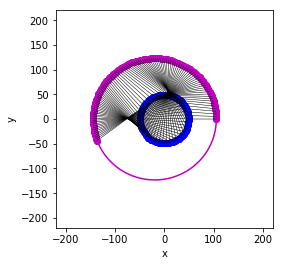

In [5]:
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([-220,220])
ax.set_ylim([-220,220])
plt.axes().set_aspect('equal')
plt.xlabel('x')
plt.ylabel('y')

# Plot only every 't_res'th point, up to t_max
t_res = 5
t_max = 500
plot_orbit(ax, s, 0)
plot_orbit(ax, s, 1)

plot_position(ax, s, 0, t_res, t_max)
plot_position(ax, s, 1, t_res, t_max)

#plot_observation(ax,s,0,-1,t_res)
plot_observation(ax,s,1,0,t_res, t_max)

plt.show()
plt.savefig("orbits.png")

### Fit with a Ptolemian Model

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# Analytic description of epicycles with radius a and rotation speed w at time t
# t must not be an array

def f_x(a, w, p, t):
    return np.sum(a * np.cos(w * t + p))

def f_y(a, w, p, t):
    return np.sum(a * np.sin(w * t + p))

def f_phi(a, w, p, t):
    return np.arctan2(f_y(a, w, p, t), f_x(a, w, p, t))

In [8]:
#a = np.array([5., 3., 0.5])
#w = np.array([0.5, 2., 7.])
#p = np.array([0., 0., 0.])
#phi = [f_phi(a, w, p, i) for i in t]
#plt.plot(t, phi)
#plt.show()

In [9]:
def decode_parameters(c):
    a = c[0::3]
    w = c[1::3]
    p = c[2::3]
    return a, w, p


In [10]:
def epicycle_error(c):
    a = c[0::3]
    w = c[1::3]
    p = c[2::3]
    phi_epi = [f_phi(a, w, p, i) for i in range(n_sample)]
    return np.sum((np.unwrap(y_fit - phi_epi))**2)

def epicycle_error_independent(c_ind):
    c = np.append([1.], c_ind) 
    return epicycle_error(c)


a_bnds = (10., 120.)
w_bnds = (0.001, 0.5)
p_bnds = (0., np.pi)
c_bound = ((80,80), w_bnds, p_bnds, a_bnds,  w_bnds, p_bnds)
c_initial = np.array([51, 0.02, 3., 99, 0.01, 0.01])

def epicycle_bounded_error(c):
    a = np.sqrt((c[0::3] - c_initial[0::3]) ** 2) * np.sign(c_initial[0::3]) + c_initial[0::3]
    w = np.sqrt((c[1::3] - c_initial[1::3]) ** 2) * np.sign(c_initial[1::3]) + c_initial[1::3]
    p = c[2::3]
    phi_epi = [f_phi(a, w, p, i) for i in range(n_sample)]
    return np.sum((np.unwrap(y_fit - phi_epi))**2)


In [11]:
y_fit = phis[0:n_sample]

c0 = c_initial


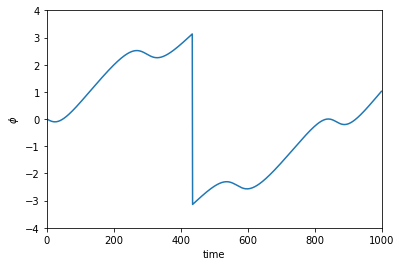

CPU times: user 375 ms, sys: 12.5 ms, total: 388 ms
Wall time: 452 ms


In [12]:
%%time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from Visualisations import *
df = pd.read_csv("test_angles_small.csv")
phis = df['phi'].values
t = df['time'].values

imax = 1000

ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.set_xlim([0,imax])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')
#plt.plot(t, phis)

plt.plot(range(imax), phis[:imax])
plt.show()


In [13]:

def find_local_extrema(x):
    n = 3
    maxima = np.array([])
    minima = np.array([])
    loops = np.array([])

    p_prev = np.zeros(n)
    d_prev = np.zeros(n)
    c_prev = np.zeros(n)

    for i, p in enumerate(x):
        
        d = p - p_prev[0]
        if(d < - np.pi):
            loops = np.append(loops, i)
            d = d + 2. * np.pi

        if(d > np.pi):
            d = d - 2. * np.pi
        c = d - d_prev[0]


        if((d * d_prev[0]) < 0):
#            print("local extremum: ", i)
            if(c < 0):
                maxima = np.append(maxima, i)
            else:
                minima = np.append(minima, i)

        p_prev = np.append(p, p_prev[:n])
        d_prev = np.append(d, d_prev[:n])
        c_prev = np.append(c, c_prev[:n])               

    print(loops)
    return maxima, minima, loops
find_local_extrema(phis)


[  435.  1306.]


(array([  269.,   538.,   841.,  1136.,  1404.,  1706.]),
 array([   25.,   330.,   599.,   889.,  1196.,  1465.,  1754.]),
 array([  435.,  1306.]))

In [14]:
def fit_features(x):
    a = np.array([1., 1.])
    w = np.array([1., 1.])
    p = np.array([1., 1.])
    
    # Find retrogrades
    maxima, minima, loops = find_local_extrema(x)
    
    # Find frequencies
    dist = loops[-1] - loops[0]
    nloop = len(loops) - 1    
    if(nloop > 0):
        w[0] = 2. * np.pi / (dist / nloop)
    else:
        print("Failed to get frequency")
    
    dist = maxima[-1] - maxima[0]
    nloop = len(maxima) - 1    
    if(nloop > 0):
        w[1] = 2. * np.pi / (dist / nloop) + w[0]
    else:
        print("Failed to get frequency")
        
    
    # Find phases
    p[0] = loops[0]*w[0] - np.pi
    p[1] = (maxima[0])*w[1] - p[0]
    
    # Find amplitudes
    a[0] = 1.
    a[1] = 0.5

    c = np.array([a[0], w[0], p[0], a[1], w[1], p[1]])
    return c
    

In [15]:
%%time
c = fit_features(phis)
c_ind = c[1:]

a_bnds = (0., 2.)
w_bnds = (0.001, 0.5)
p_bnds = (0., np.pi)
bnds = (w_bnds, p_bnds, a_bnds,  w_bnds, p_bnds)

from scipy.optimize import minimize
res = minimize(fun=epicycle_error_independent, x0=c_ind,
               method='TNC', tol=1e-8,
               bounds=bnds,
               options={
                   #'xtol': 0.001, 
                        #'eps': 0.02, 
                        'maxiter': 100000})

[  435.  1306.]
CPU times: user 1min 15s, sys: 684 ms, total: 1min 15s
Wall time: 1min 19s


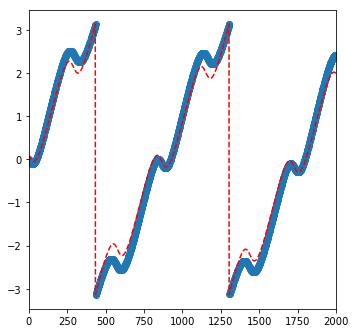

In [16]:
c = np.append(1., res.x) 
a, w, p = decode_parameters(c)

if(False):
    a = np.array([50, 100])
    w = np.array([np.sqrt(0.02)/50.*n_view,0.1/100*n_view])
    p = np.array([np.pi,0])


#t = np.arange(0, n_sim/n_view)*n_view
t = np.arange(0, n_sample)
phi_epi = [f_phi(a, w, p, i) for i in t]

ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,t[n_sample - 1]])
plt.gcf().set_size_inches(5.5, 5.5)

plt.scatter(t[0:n_sample], y_fit[0:n_sample])
plt.plot(t[0:n_sample], phi_epi[0:n_sample], color='r', linestyle='dashed')
plt.savefig("ptolemian_mars.png")
plt.show()

[  266.   912.  1562.  2212.  2862.  3507.  4038.  4685.  5336.  5986.
  6635.  7177.  7278.  7811.  8459.  9109.  9760.]
[ 1.          0.01058889 -0.3249467   0.5         0.02887295  9.53541799]


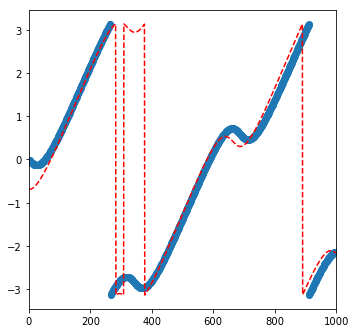

In [12]:
c = fit_features(phis)
print(c)
a, w, p = decode_parameters(c)
#t = np.arange(0, n_sim/n_view)*n_view
t = np.arange(0, n_sample)
phi_epi = [f_phi(a, w, p, i) for i in t]

ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,t[n_sample - 1]])
plt.gcf().set_size_inches(5.5, 5.5)

plt.scatter(t[0:n_sample], y_fit[0:n_sample])
plt.plot(t[0:n_sample], phi_epi[0:n_sample], color='r', linestyle='dashed')
plt.savefig("ptolemian_mars.png")
plt.show()

In [13]:
c

array([ 1.        ,  0.01058889, -0.3249467 ,  0.5       ,  0.02887295,
        9.53541799])

In [14]:
import cma
c_ind = c[1:]
es = cma.CMAEvolutionStrategy(x0=c_ind, sigma0 = 0.001)
es.optimize(epicycle_error_independent)
es.result_pretty()

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=492541, Tue Jun 19 15:49:06 2018)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.259617684499900e+02 1.0e+00 1.04e-03  1e-03  1e-03 0:00.2
    2     16 2.763428581125074e+02 1.4e+00 1.12e-03  1e-03  1e-03 0:00.5
    3     24 4.247000989112744e+02 1.8e+00 1.21e-03  1e-03  1e-03 0:00.7
   21    168 2.079031061406974e+02 8.2e+00 6.89e-04  1e-04  9e-04 0:03.8
   45    360 2.017332488702846e+02 6.9e+01 7.26e-04  4e-05  2e-03 0:07.8
   75    600 1.236478436869685e+02 9.0e+02 1.59e-02  1e-04  8e-02 0:12.9
  100    800 1.202184288869263e+02 1.3e+03 7.09e-03  2e-05  1e-02 0:17.0
  143   1144 1.198113350676168e+02 1.7e+03 4.09e-04  3e-07  2e-04 0:24.1
  191   1528 1.198113267465568e+02 1.4e+03 1.85e-06  2e-10  1e-07 0:32.1
  200   1600 1.198113267465554e+02 1.5e+03 3.20e-07  2e-11  1e-08 0:33.6
  212   1696 1.198113267465553e+02 1.3e+03 2.70e-07  1e-11  7e-09 0:35.7
termination on tolfun=1e-11
final/b

CMAEvolutionStrategyResult(xbest=array([ 0.01035531, -0.19125785,  0.10783373,  0.03311873]), fbest=119.81132674655528, evals_best=1667, evaluations=1696, iterations=212, xfavorite=array([ 0.01035531, -0.19125785,  0.10783373,  0.03311873]), stds=array([  1.36208035e-11,   7.14443182e-09,   3.65991936e-09,
         5.53007087e-11]))

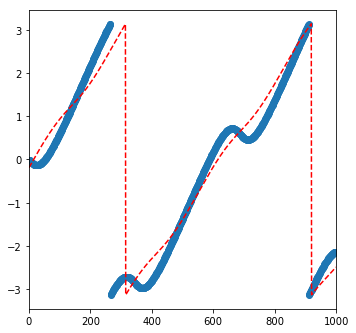

In [15]:
c = np.append(1., es.result.xbest) 
a, w, p = decode_parameters(c)

if(False):
    a = np.array([50, 100])
    w = np.array([np.sqrt(0.02)/50.*n_view,0.1/100*n_view])
    p = np.array([np.pi,0])


#t = np.arange(0, n_sim/n_view)*n_view
t = np.arange(0, n_sample)
phi_epi = [f_phi(a, w, p, i) for i in t]

ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,t[n_sample - 1]])
plt.gcf().set_size_inches(5.5, 5.5)

plt.scatter(t[0:n_sample], y_fit[0:n_sample])
plt.plot(t[0:n_sample], phi_epi[0:n_sample], color='r', linestyle='dashed')
plt.savefig("ptolemian_mars.png")
plt.show()

In [16]:
c_ind

array([ 0.01058889, -0.3249467 ,  0.5       ,  0.02887295])

In [ ]:
p

In [ ]:
c_ind

### Predict the planet angle from time series with LSTM

In [16]:
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [17]:
#scaler = MinMaxScaler(feature_range=(0, 1))
#dataset = scaler.fit_transform(s.get_phi(1).reshape(-1, 1))

In [18]:
def make_time_series(dataset, look_back=1):
    n_feat = dataset.shape[1]
    x, y = np.ndarray(shape=(0, look_back, n_feat)), np.array([])
    length = len(dataset) - look_back - 1
    for i in range(length):
        a = dataset[i:(i + look_back)].reshape(-1, look_back, n_feat)
        x = np.concatenate((x, a), axis=0)
        y = np.concatenate((y, [dataset[i + look_back, 0]]), axis=0)
#    x = np.reshape(x, (x.shape[0], look_back, x.shape[1]))
    return x, y

# reshape input to be [samples, time steps, features]

test = s.get_phi(1).reshape(-1, 1) / np.pi
x, y = make_time_series(test, n_sample)
#x = np.reshape(x, (x.shape[0], 1, x.shape[1]))

In [19]:
x.shape

(1899, 100, 1)

In [20]:
x.shape[0]

1899

In [21]:
len(y)

1899

In [26]:
94*5

470

In [53]:
# create and fit the LSTM network
#model = Sequential()
#model.add(LSTM(4, input_shape=(1, look_back)))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(x, y, epochs=5, batch_size=1, verbose=2)

inputs = Input(shape=(n_sample, 1), dtype='float', name='main_input')
#inputs = Input(shape=(1, n), dtype='float', name='main_input')
# why not (n, 1) ?
# CHECK THIS! FEATURES VS TIMESTEPS

layer = LSTM(8)(inputs)
predictions = Dense(1)(layer)
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='mean_squared_error')

model.fit(x, y, epochs=1, batch_size=1, verbose=2)


Epoch 1/1
360s - loss: 0.0655


In [54]:
y_pred = model.predict(x) * np.pi
y_true = y * np.pi

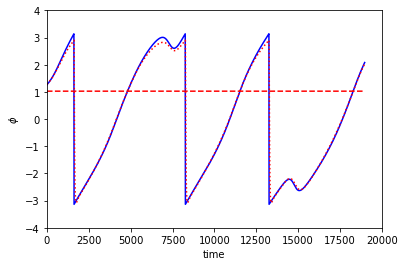

In [55]:
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,n_sim])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')
plt.plot(t[:len(y_pred)], y_true, color='b')
plt.plot(t[:len(y_pred)], y_pred, color='r', linestyle='dotted')

phi_epi = [f_phi(a, w, p, i) for i in t]
plt.plot(t[:len(y_pred)], phi_epi[n_sample:n_sample + len(y_pred)], color='r', linestyle='dashed')
plt.show()

plt.savefig("predicted_lstm.png")
plt.show()

### Long time extrapolation

In [56]:
phis = s.get_phi(1).reshape(-1,1)
x, y = make_time_series(phis/np.pi, n_sample)
xx = np.reshape(x[0], newshape=(-1, n_sample, n_feat))
y_ex = np.zeros(len(y))

for i in np.arange(0,len(y)):
    new_y = model.predict(xx)
    y_ex[i] = new_y
    xx = np.concatenate((xx, np.reshape(new_y,newshape=(-1, 1, n_feat))), axis=1)
    xx = xx[:,1:n_sample+1]


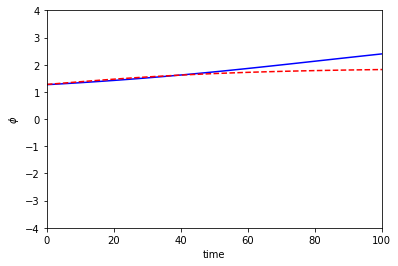

In [57]:
y_pred = y_ex * np.pi
y_true = y * np.pi
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,100])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')
plt.plot(range(len(y_pred)), y_true, color='b')
plt.plot(range(len(y_pred)), y_pred, color='r', linestyle='dashed')
plt.savefig("extrapolated_mars.png")
plt.show()

obviously fails... yet...

## Complex planetary system

Now we move to the system Gnos, where the motion of the celestial bodies is more confusing and harder to figure out.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from Visualisations import *

from Transformations import *
import Generate as gen

In [ ]:
n_sim = 20000
n_view = 10
s = gen.System()
s.force = s.force_double_sun
s.add_body(x=[90., 82.], v=[-0.02, +0.067], m=0.00001)
s.add_body(x=[70., 123.], v=[-0.07, +0.07], m=0.00001)
s.add_body(x=[144., 76.], v=[-0.075, +0.075], m=0.00001)
s.add_body(x=[174., 176.], v=[-0.025, +0.035], m=0.00001)
s.add_body(x=[0., 0.], v=[0., 0.], m=1.)
s.simulate(n_sim)
s.view(0, n_view)

### Visualise the system

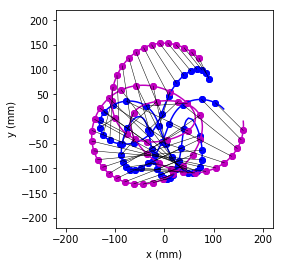

In [34]:
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([-220,220])
ax.set_ylim([-220,220])
plt.axes().set_aspect('equal')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

# Plot only every 't_res'th point, up to t_max
t_res = 20
t_max = 1200
plot_orbit(ax, s, 0, t_max)
plot_orbit(ax, s, 1, t_max)
plot_position(ax, s, 0, t_res, t_max)
plot_position(ax, s, 1, t_res, t_max)
#plot_observation(ax,s,0,-1,t_res)
plot_observation(ax,s,1,0,t_res, t_max)
plt.savefig("orbits_binary.png")
plt.show()

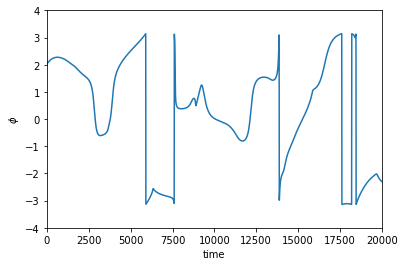

In [35]:
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,n_sim])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')


phis = s.get_phi(1)
t = np.arange(0, n_sim/n_view)*n_view

plt.plot(t, phis)
plt.savefig("mars_angle_binary.png")
plt.show()

In [36]:
phis = s.get_phi(1)
phis /= np.pi
series = make_time_series(phis, depth=n+1)
y = series[:,n].reshape(-1,1)
x = series[:,0:n].reshape(-1,n)

NameError: name 'n' is not defined

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(n,), dtype='float', name='main_input')
layer = Dense(90, activation='relu', kernel_initializer='normal')(inputs)
layer = Dense(90, activation='relu', kernel_initializer='normal')(layer)
predictions = Dense(1, kernel_initializer='normal')(layer)
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='mean_squared_error')

model.fit(x, y)

In [37]:
t_max = 10000
phis = s.get_phi(1)/np.pi
series = make_time_series(phis, depth=n+1)
y = series[:t_max,n].reshape(-1,1)
x = series[:t_max,0:n].reshape(-1,n)
y_pred = model.predict(x) * np.pi
y_true = y * np.pi
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,t_max])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')
plt.plot(t[:len(y_pred)], y_true, color='b')
plt.plot(t[:len(y_pred)], y_pred, color='r', linestyle='dashed')
plt.savefig("prediction_mars_binary.png")
plt.show()

NameError: name 'n' is not defined

In [ ]:
phis = s.get_phi(3)/np.pi
series = make_time_series(phis, depth=n+1)
y = series[:,n].reshape(-1,1)
x = series[:,0:n].reshape(-1,n)
y_pred = model.predict(x)*np.pi
y_true = y*np.pi
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,t_max])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')
plt.plot(t[:len(y_pred)], y_true, color='b')
plt.plot(t[:len(y_pred)], y_pred, color='r', linestyle='dashed')
plt.savefig("prediction_uranus_binary.png")
plt.show()

# Pendulum system

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from Visualisations import *

from Transformations import *
import Generate as gen

n_sim = 50000
n_view = 50
s = gen.System()
s.force = s.force_pendulum_spring
s.g = 0.
s.k = 0.02
s.f = -0.0000001
s.add_body(x=[0., 0.], v=[0., 0.], m=1000000., stretch=0.)
s.add_body(x=[-0.1, -0.4], v=[0., -0.], m=20000., stretch=0.)
s.add_body(x=[-0.1, -0.5], v=[0., -0.], m=10., stretch=0.)

s.simulate(n_sim)
s.view(1, n_view)

ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([-0.5,0.5])
ax.set_ylim([-0.9,0.2])
plt.axes().set_aspect('equal')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

# Plot only every 't_res'th point, up to t_max
t_res = 1
t_max = 100
plot_orbit(ax, s, 0)
plot_orbit(ax, s, 1)
plot_orbit(ax, s, 2)

plot_position(ax, s, 0, t_res, t_max)
plot_position(ax, s, 1, t_res, t_max)
plot_position(ax, s, 2, t_res, t_max)

plot_observation(ax,s,2,1, t_res, t_max)

plt.savefig("orbits_pendulum_double_dense.png")
plt.show()

In [ ]:
# Plot only every 't_res'th point, up to t_max
t_res = 20
t_max = n_sim

ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([-0.5,0.5])
ax.set_ylim([-0.9,0.2])
plt.axes().set_aspect('equal')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

plot_orbit(ax, s, 0, t_max)
plot_orbit(ax, s, 1, t_max)
plot_orbit(ax, s, 2, t_max)

plot_position(ax, s, 0, t_res, t_max)
plot_position(ax, s, 1, t_res, t_max)
plot_position(ax, s, 2, t_res, t_max)

plot_observation(ax,s,2,1, t_res, t_max)
plt.savefig("orbits_pendulum_double_rare.png")
plt.show()


In [ ]:
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,n_sim])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')

phis = s.get_phi(2)
t = np.arange(0, n_sim/n_view)*n_view

plt.plot(t, phis)
plt.savefig("mars_angle_pendulum_double.png")
plt.show()

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from Visualisations import *

from Transformations import *
import Generate as gen

n_sim = 10000
n_view = 100
s = gen.System()
s.force = s.force_pendulum_spring
s.g = 0.
s.k = 0.02
s.f = -0.0000001
s.add_body(x=[0., 0.], v=[0., 0.], m=100000., stretch=0.)
s.add_body(x=[-0.1, -0.2], v=[0., -0.], m=2000., stretch=0.)
s.add_body(x=[0., -0.5], v=[0., -0.], m=10., stretch=0.)
s.add_body(x=[0.1, -0.6], v=[0., -0.], m=0.01, stretch=0.)

s.simulate(n_sim)
s.view(1, n_view)

ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([-0.5,0.5])
ax.set_ylim([-0.9,0.2])
plt.axes().set_aspect('equal')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

# Plot only every 't_res'th point, up to t_max
t_res = 1
t_max = 100
plot_orbit(ax, s, 0)
plot_orbit(ax, s, 1)
plot_orbit(ax, s, 2)
plot_orbit(ax, s, 3)

plot_position(ax, s, 0, t_res, t_max)
plot_position(ax, s, 1, t_res, t_max)
plot_position(ax, s, 2, t_res, t_max)
plot_position(ax, s, 3, t_res, t_max)

plot_observation(ax,s,1,0, t_res, t_max)
plot_observation(ax,s,2,1, t_res, t_max)
plot_observation(ax,s,3,2, t_res, t_max)

plt.savefig("orbits_pendulum.png")
plt.show()

In [ ]:
# Plot only every 't_res'th point, up to t_max
t_res = 20
t_max = 500

ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([-0.5,0.5])
ax.set_ylim([-0.9,0.2])
plt.axes().set_aspect('equal')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

plot_orbit(ax, s, 0, t_max)
plot_orbit(ax, s, 1, t_max)
plot_orbit(ax, s, 2, t_max)
plot_orbit(ax, s, 3, t_max)

plot_position(ax, s, 0, t_res, t_max)
plot_position(ax, s, 1, t_res, t_max)
plot_position(ax, s, 2, t_res, t_max)
plot_position(ax, s, 3, t_res, t_max)

plot_observation(ax,s,1,0, t_res, t_max)
plot_observation(ax,s,2,1, t_res, t_max)
plot_observation(ax,s,3,2, t_res, t_max)



In [ ]:
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,n_sim])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')


phis = s.get_phi(2)
t = np.arange(0, n_sim/n_view)*n_view

plt.plot(t, phis)
plt.savefig("mars_angle_pendulum.png")
plt.show()

In [ ]:
n = 20
phis = s.get_phi(1)
phis /= np.pi
series = make_time_series(phis, depth=n+1)
y = series[:,n].reshape(-1,1)
x = series[:,0:n].reshape(-1,n)

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(n,), dtype='float', name='main_input')
layer = Dense(90, activation='relu', kernel_initializer='normal')(inputs)
layer = Dense(90, activation='relu', kernel_initializer='normal')(layer)
predictions = Dense(1, kernel_initializer='normal')(layer)
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='mean_squared_error')

model.fit(x, y)

In [ ]:
t_max = 10000
phis = s.get_phi(1)/np.pi
series = make_time_series(phis, depth=n+1)
y = series[:t_max,n].reshape(-1,1)
x = series[:t_max,0:n].reshape(-1,n)
y_pred = model.predict(x) * np.pi
y_true = y * np.pi
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,t_max])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')
plt.plot(t[:len(y_pred)], y_true, color='b')
plt.plot(t[:len(y_pred)], y_pred, color='r', linestyle='dashed')
plt.savefig("prediction_mars_pendulum.png")
plt.show()

In [ ]:
phis = s.get_phi(3)/np.pi
series = make_time_series(phis, depth=n+1)
y = series[:,n].reshape(-1,1)
x = series[:,0:n].reshape(-1,n)
y_pred = model.predict(x)*np.pi
y_true = y*np.pi
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,t_max])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')
plt.plot(t[:len(y_pred)], y_true, color='b')
plt.plot(t[:len(y_pred)], y_pred, color='r', linestyle='dashed')
plt.savefig("prediction_uranus_pendulum.png")
plt.show()